# [RSNA Screening Mammography Breast Cancer Detection](https://www.kaggle.com/c/petfinder-pawpularity-score)
> Find breast cancers in screening mammograms

![](https://storage.googleapis.com/kaggle-competitions/kaggle/39272/logos/header.png?t=2022-11-28-17-29-35)

# Idea:
* In this notebook will classify `breast cancer` from Mammography images. Intially, we'll use CNN models then we'll move towards Transformer models.
* There is a huge **class-imbalance** between cancer and non-cancer class which makes it difficult for the model to learn properly. Moreover, cancer size could be from very small to very large, so there is also **pixel-imbalance** which makes the task even more difficult. There are couple of ways to handle imbalance ex: `WeightedLoss`, `FocalLoss`, `Upsample`. In our notebook we'll use both `FocalLoss` and `Upsample`.
* We'll use **ROI: Regoin Of Interest** instead of whole image as most of the image contains no information (black). To avoid distortion we'll also use **Rectangule** image for training instead of Squares
* As dataset is quite large we'll utilize `TPU-VM` aka `Local TPU` to speed up the training.
* We'll use `cancer` column as target.
* We'll use **CNN** model: EfficientNet for our training.
* We won't use **Tabular** feature in this notebook.
* **Wandb** is integrated hence we can use this notebook to track which experiemnt is peforming better.
* We'll maximize the `pF1` score using **Threshold**


# Notebooks
* Only Image:
    * ROI:
        * train: [RSNA-BCD: EfficientNet [TF][TPU-1VM][Train]](https://www.kaggle.com/code/awsaf49/rsna-bcd-efficientnet-tf-tpu-1vm-train)
        * infer: [RSNA-BCD: EfficientNet [TF][TPU-1VM][Infer]](https://www.kaggle.com/code/awsaf49/rsna-bcd-efficientnet-tf-tpu-1vm-infer)
    * NoROI + KerasCV: 
        * train: [RSNA-BCD: NoROI KerasCV [TF][Train]](https://www.kaggle.com/awsaf49/rsna-bcd-noroi-kerascv-tf-train/)
        * infer: [RSNA-BCD: NoROI KerasCV [TF][Infer]](https://www.kaggle.com/awsaf49/rsna-bcd-noroi-kerascv-tf-infer/)
* Dataset:
    * ROI:
        * [RSNA-BCD: ROI 1024x PNG Dataset](https://www.kaggle.com/datasets/awsaf49/rsna-bcd-roi-1024x-png-dataset)
    * NoROI:
        * [RSNA-BCD: 512 PNG v2 PNG Dataset](https://www.kaggle.com/datasets/awsaf49/rsnabcd-512-png-v2-dataset)

# Overview

## ROI + Rectangle Image
* This notebook will **ROI (Region Of Interest)** image instead of full image. ROI is extracted using `OpenCV` (binary + max contour).
* This notebook will use **rectangle** image (width!=height) training to avoid distortion.

## Upsample `Cancer`
* Upsample the cancer data `10x` to reduce class_imbalance effect on loss

## `TPU-VM` aka `Local TPU`
* It doesn't require `GCS_PATH` like normaly `TPU`. So, for this, we don't have to make our dataset **public** anymore. 
* As datasets will be read from local path, it should speed up the first epoch (for normal `tpu` first epoch is quite slow).

## Augmentations:
* Random - Horizontal Flip
* Random - Brightness, Contrast, Hue, Saturation
* Coarse Dropout
* MixUp - soon

## WandB Integration:
* You can track your training using **wandb**
* It's very easy to compare model's performance using **wandb**.

## `pF1` Maximization:
* Use simple empirical method to attain best `threshold` for max `pF1`

# Update
* `v8 - 08/12/202`:
    * MixUp and CutMix added
    * Save gradcam in local directory
* `v9 - 09/12/2022`:
    * Swap MixUp->CutMix to CutMix->MixUp
    * Number of folds 4, (saves time also can't submit 5 folds in test due to timeout)
* `v10 - 10/12/2022`:
    * Moved from pydicom to dicomsdl
* `v18` - `19/12/2022`:
    * Integration of `EfficinetNetV2` through `keras_cv_attention_models` library
* `v22` - `18/01/2023`:
    * `WandbModelCheckpoint` and `WandbModelCheckpoint` are used now

# Install Libraries

## Install for `TPU VM v3-8`
Usually these libraries come pre-installed for other accelerators but fo `tpu-vm` we need to install them manually. If you want to use rather `remote-TPU` or `GPU` or `CPU`, then comment out the following cell.

In [1]:
!pip install -q /lib/wheels/tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl
!pip install -q tensorflow-addons==0.18.0
!pip install -q tensorflow-probability==0.17.0
!pip install -q opencv-python-headless
!pip install -q seaborn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.11.0 requires tensorflow<2.12,>=2.11.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.9.1 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


## Install Custom Libraries

In [2]:
!pip install -q keras-cv-attention-models
!pip install -qU wandb
!pip install -qU scikit-learn

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
elegy 0.8.6 requires wandb<0.13.0,>=0.12.10, but you have wandb 0.13.9 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


# Import Libraries

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # to avoid too many logging messages
import pandas as pd, numpy as np, random, shutil
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import sklearn
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import wandb
import yaml

from IPython import display as ipd
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

[percpu.cc : 560] RAW: rseq syscall failed with errno 1
[percpu.cc : 552] RAW: rseq syscall failed with errno 1


# Version Check

In [4]:
print('np:', np.__version__)
print('pd:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('tf:',tf.__version__)
print('tfp:', tfp.__version__)
print('tfa:', tfa.__version__)
print('w&b:', wandb.__version__)

np: 1.24.1
pd: 1.5.2
sklearn: 1.2.0
tf: 2.9.1
tfp: 0.17.0
tfa: 0.18.0
w&b: 0.13.9


# Wandb

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management

Some of the cool features of **W&B**:

* Track, compare, and visualize ML experiments
* Get live metrics, terminal logs, and system stats streamed to the centralized dashboard.
* Explain how your model works, show graphs of how model versions improved, discuss bugs, and demonstrate progress towards milestones.

> **Note:** `kaggle_secrets` has not been added to `TPU-VM` yet, so run anonymously then go to the dashbaord and simply `claim` the run.

In [5]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")

    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Configuration

In [6]:
class CFG:
    wandb         = True
    competition   = 'rsna-bcd' 
    _wandb_kernel = 'awsaf49'
    debug         = False
    comment       = 'EfficientNetV1B4-1024x512-roi-up=10-lr4-focal-vflip-wb'
    exp_name      = 'roi-v2-fix' # name of the experiment, folds will be grouped using 'exp_name'
    
    # use verbose=0 for silent, vebose=1 for interactive,
    verbose      = 1
    display_plot = True

    # device
    device = "TPU-VM" #or "GPU"

    model_name = 'EfficientNetV1B4'

    # seed for data-split, layer init, augs
    seed = 42

    # number of folds for data-split
    folds = 5
    
    # which folds to train
    selected_folds = [0, 1, 2]

    # size of the image
    img_size = [1024, 512]
#     eq_dim = np.prod(img_size)**0.5

    # batch_size and epochs
    batch_size = 28
    epochs = 8
    
    # upsample
    upsample = 10

    # loss
    loss      = 'Focal'  # BCE, Focal
    use_cw    = False  # use class weight or not
    
    # optimizer
    optimizer = 'Adam'

    # augmentation
    augment   = True

    # scale-shift-rotate-shear
    transform = 0.90  # transform prob
    fill_mode = 'constant'
    rot    = 2.0
    shr    = 2.0
    hzoom  = 50.0
    wzoom  = 50.0
    hshift = 10.0
    wshift = 10.0

    # flip
    hflip = True
    vflip = True

    # clip
    clip = False

    # lr-scheduler
    scheduler   = 'exp' # cosine

    # dropout
    drop_prob   = 0.6
    drop_cnt    = 10
    drop_size   = 0.08
    
    # cut-mix-up
    mixup_prob = 0.0
    mixup_alpha = 0.5
    
    cutmix_prob = 0.0
    cutmix_alpha = 2.5

    # pixel-augment
    pixel_aug = 0.90  # prob of pixel_aug
    sat  = [0.7, 1.3]
    cont = [0.8, 1.2]
    bri  = 0.15
    hue  = 0.05

    # test-time augs
    tta = 1
    
    # target column
    target_col  = ['cancer']

# Reproducibility

In [7]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(CFG.seed)

seeding done!!!


# Device Configs
This notebook is compatible for **remote-tpu**, **local-tpu**, **multi-gpu** and **single-gpu**. Simple change to `device="TPU"` for **remote-tpu** and `device="TPU-VM"` for **local-tpu** and finally, `device="GPU"` for single or multi-gpu.

In [8]:
if "TPU" in CFG.device:
    tpu = 'local' if CFG.device=='TPU-VM' else None
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
    except:
        CFG.device = "GPU"
        
if CFG.device == "GPU"  or CFG.device=="CPU":
    ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
    if ngpu>1:
        print("Using multi GPU")
        strategy = tf.distribute.MirroredStrategy()
    elif ngpu==1:
        print("Using single GPU")
        strategy = tf.distribute.get_strategy()
    else:
        print("Using CPU")
        strategy = tf.distribute.get_strategy()
        CFG.device = "CPU"

if CFG.device == "GPU":
    print("Num GPUs Available: ", ngpu)
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/tas

# GCS Path for TPU
* Remote-TPU requires **GCS** path. Luckily Kaggle Provides that for us :)
* Local-TPU aka TPU-VM doesn't need GCS path =)

In [9]:
BASE_PATH = f'/kaggle/input/rsna-bcd-roi-{CFG.img_size[0]}x{CFG.img_size[1]}-png-v2-dataset'

if CFG.device=="TPU":
    from kaggle_datasets import KaggleDatasets
    GCS_PATH = KaggleDatasets().get_gcs_path(BASE_PATH.split('/')[-1])

# Meta Data

In [10]:
# use gcs_path for remote-tpu
if CFG.device=="TPU":
    BASE_PATH = GCS_PATH

# train
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['image_path'] = f'{BASE_PATH}/train_images'\
                    + '/' + df.patient_id.astype(str)\
                    + '/' + df.image_id.astype(str)\
                    + '.png'
print('Train:')
display(df.head(2))

# test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['image_path'] = f'{BASE_PATH}/test_images'\
                    + '/' + test_df.patient_id.astype(str)\
                    + '/' + test_df.image_id.astype(str)\
                    + '.png'
print('\nTest:')
display(test_df.head(2))

Train:


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_path,width,height
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-bcd-roi-1024x512-png-v2-dat...,223,646
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-bcd-roi-1024x512-png-v2-dat...,257,1022



Test:


,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,image_path,width,height
0,2,10008,736471439,L,MLO,81,0,21,10008_L,/kaggle/input/rsna-bcd-roi-1024x512-png-v2-dat...,590,989
1,2,10008,1591370361,L,CC,81,0,21,10008_L,/kaggle/input/rsna-bcd-roi-1024x512-png-v2-dat...,505,915


# Check If Data Exist?

In [11]:
tf.io.gfile.exists(df.image_path.iloc[0]), tf.io.gfile.exists(test_df.image_path.iloc[0])

(True, True)

## Train-Test Ditribution

In [12]:
print('train_files:',df.shape[0])
print('test_files:',test_df.shape[0])

train_files: 54706
test_files: 4


# Data Split
* Data is splited while stratifying, 'laterality', 'view', 'age','cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density','machine_id', 'difficult_negative_case','cancer'.
* To avoid leakage, data is also split keeping images from same patient in either train or valid not in both.
* `StratifiedGroupKFold` does the both job **stratifying** and **group** split.



In [13]:
num_bins = 5
df["age_bin"] = pd.cut(df['age'].values.reshape(-1), bins=num_bins, labels=False)

strat_cols = [
    'laterality', 'view', 'biopsy','invasive', 'BIRADS', 'age_bin',
    'implant', 'density','machine_id', 'difficult_negative_case',
    'cancer',
]

df['stratify'] = ''
for col in strat_cols:
    df['stratify'] += df[col].astype(str)

skf = StratifiedGroupKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['stratify'], df["patient_id"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold', "cancer"]).size())

/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:909: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


fold  cancer
0.0   0         10592
      1           248
1.0   0         10767
      1           238
2.0   0         10747
      1           205
3.0   0         10693
      1           206
4.0   0         10749
      1           261
dtype: int64

# Data Augmentation
Used simple augmentations, some of them may hurt the model.
* RandomFlip (Left-Right)
* No Rotation
* RandomBrightness
* RndomContrast
* Shear
* Zoom
* Coarsee Dropout/Cutout

In [14]:
def get_mat(shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    #rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
#     c1   = tf.math.cos(rotation)
#     s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
#     rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
#                                    -s1,  c1,   zero, 
#                                    zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                               zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    

    return  K.dot(shear_matrix,K.dot(zoom_matrix, shift_matrix)) #K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))                  

def transform(image, DIM=CFG.img_size):#[rot,shr,h_zoom,w_zoom,h_shift,w_shift]):
    if DIM[0]>DIM[1]:
        diff  = (DIM[0]-DIM[1])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[0, 0], [pad[0], pad[1]],[0, 0]])
        NEW_DIM = DIM[0]
    elif DIM[0]<DIM[1]:
        diff  = (DIM[1]-DIM[0])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[pad[0], pad[1]], [0, 0],[0, 0]])
        NEW_DIM = DIM[1]
    
    rot = CFG.rot * tf.random.normal([1], dtype='float32')
    shr = CFG.shr * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / CFG.hzoom
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / CFG.wzoom
    h_shift = CFG.hshift * tf.random.normal([1], dtype='float32') 
    w_shift = CFG.wshift * tf.random.normal([1], dtype='float32') 
    
    transformation_matrix=tf.linalg.inv(get_mat(shr,h_zoom,w_zoom,h_shift,w_shift))
    
    flat_tensor=tfa.image.transform_ops.matrices_to_flat_transforms(transformation_matrix)
    
    image=tfa.image.transform(image,flat_tensor, fill_mode=CFG.fill_mode)
    
    rotation = math.pi * rot / 180.
    
    image=tfa.image.rotate(image,-rotation, fill_mode=CFG.fill_mode)
    
    if DIM[0]>DIM[1]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,3])
        image = image[:, pad[0]:-pad[1],:]
    elif DIM[1]>DIM[0]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,3])
        image = image[pad[0]:-pad[1],:,:]
    image = tf.reshape(image, [*DIM, 3])    
    return image

def dropout(image,DIM=CFG.img_size, PROBABILITY = 0.6, CT = 5, SZ = 0.1):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): 
        return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM[1]),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM[0]),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*min(DIM),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM[0],y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM[1],x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3], dtype = image.dtype) 
        three = image[ya:yb,xb:DIM[1],:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM[0],:,:]],axis=0)
        image = tf.reshape(image,[*DIM,3])

#     image = tf.reshape(image,[*DIM,3])
    return image

## CutMixUp

In [15]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(
        shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)


def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(
        shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

# mixup
def get_mixup(alpha=0.2, prob=0.5):
    @tf.function
    def mixup(images, labels, alpha=alpha, prob=prob):
        if random_float() > prob:
            return images, labels

        image_shape = tf.shape(images)
        label_shape = tf.shape(labels)

        beta = tfp.distributions.Beta(alpha, alpha)
        lam = beta.sample(1)[0]

        images = lam * images + (1.0 - lam) * tf.roll(images, shift=1, axis=0)
        labels = lam * labels + (1.0 - lam) * tf.roll(labels, shift=1, axis=0)

        images = tf.reshape(images, image_shape)
        labels = tf.reshape(labels, label_shape)
        return images, labels
    return mixup

# cutmix
def get_cutmix(alpha, prob=0.5):
    @tf.function
    def cutmix(images, labels, alpha=alpha, prob=prob):
        if random_float() > prob:
            return images, labels
        image_shape = tf.shape(images)
        label_shape = tf.shape(labels)
        
        W = tf.cast(image_shape[2], tf.int32)
        H = tf.cast(image_shape[1], tf.int32)

        beta = tfp.distributions.Beta(alpha, alpha)
        lam = beta.sample(1)[0]

        images_rolled = tf.roll(images, shift=1, axis=0)
        labels_rolled = tf.roll(labels, shift=1, axis=0)

        r_x = random_int([], minval=0, maxval=W)
        r_y = random_int([], minval=0, maxval=H)
        r = 0.5 * tf.math.sqrt(1.0 - lam)
        r_w_half = tf.cast(r * tf.cast(W, tf.float32), tf.int32)
        r_h_half = tf.cast(r * tf.cast(H, tf.float32), tf.int32)

        x1 = tf.cast(tf.clip_by_value(r_x - r_w_half, 0, W), tf.int32)
        x2 = tf.cast(tf.clip_by_value(r_x + r_w_half, 0, W), tf.int32)
        y1 = tf.cast(tf.clip_by_value(r_y - r_h_half, 0, H), tf.int32)
        y2 = tf.cast(tf.clip_by_value(r_y + r_h_half, 0, H), tf.int32)

        # outer-pad patch -> [0, 0, 1, 1, 0, 0]
        patch1 = images[:, y1:y2, x1:x2, :]  # [batch, height, width, channel]
        patch1 = tf.pad(
            patch1, [[0, 0], [y1, H - y2], [x1, W - x2], [0, 0]])  # outer-pad

        # inner-pad patch -> [1, 1, 0, 0, 1, 1]
        patch2 = images_rolled[:, y1:y2, x1:x2, :]
        patch2 = tf.pad(
            patch2, [[0, 0], [y1, H - y2], [x1, W - x2], [0, 0]])  # outer-pad
        patch2 = images_rolled - patch2  # inner-pad = img - outer-pad

        images = patch1 + patch2  # cutmix img

        lam = tf.cast((1.0 - (x2 - x1) * (y2 - y1) / (W * H)), tf.float32)  # no H as (y1 - y2)/H = 1
        labels = lam * labels + (1.0 - lam) * labels_rolled  # cutmix label

        images = tf.reshape(images, image_shape)
        labels = tf.reshape(labels, label_shape)

        return images, labels

    return cutmix

## Data Pipeline
* Reads the raw file and then decodes it to tf.Tensor
* Resizes the image in desired size
* Chages the datatype to **float32**
* Caches the Data for boosting up the speed.
* Uses Augmentations to reduce overfitting and make model more robust.
* Finally, splits the data into batches.


In [16]:
def build_decoder(with_labels=True, target_size=CFG.img_size, ext='png'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.image.resize(img, target_size, method='bilinear')
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*target_size, 3])

        return img
    
    def decode_with_labels(path, label):
        return decode(path), tf.cast(label, tf.float32)
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True, dim=CFG.img_size):
    def augment(img, dim=dim):
        if random_float() < CFG.transform:
            img = transform(img,DIM=dim)
        img = tf.image.random_flip_left_right(img) if CFG.hflip else img
        img = tf.image.random_flip_up_down(img) if CFG.vflip else img
        if random_float() < CFG.pixel_aug:
            img = tf.image.random_hue(img, CFG.hue)
            img = tf.image.random_saturation(img, CFG.sat[0], CFG.sat[1])
            img = tf.image.random_contrast(img, CFG.cont[0], CFG.cont[1])
            img = tf.image.random_brightness(img, CFG.bri)
        img = tf.clip_by_value(img, 0, 1)  if CFG.clip else img         
        img = tf.reshape(img, [*dim, 3])
        return img
    
    def augment_with_labels(img, label):    
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    if augment and labels is not None:
        ds = ds.map(lambda img, label: (dropout(img, 
                                               DIM=CFG.img_size, 
                                               PROBABILITY=CFG.drop_prob, 
                                               CT=CFG.drop_cnt,
                                               SZ=CFG.drop_size), label),num_parallel_calls=AUTO)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    if augment and labels is not None:
        if CFG.cutmix_prob:
            ds = ds.map(get_cutmix(alpha=CFG.cutmix_alpha,prob=CFG.cutmix_prob),num_parallel_calls=AUTO)
        if CFG.mixup_prob:
            ds = ds.map(get_mixup(alpha=CFG.mixup_alpha,prob=CFG.mixup_prob),num_parallel_calls=AUTO)
    ds = ds.prefetch(AUTO)
    return ds

## Visualization
* Check if augmentation is working properly or not.

In [17]:
def display_batch(batch, size=2):
    if isinstance(batch, tuple):
        imgs, tars = batch
    else:
        imgs = batch
        tars = None
    tars = tars.numpy().squeeze()
    plt.figure(figsize=(size*2, 10))
    for img_idx in range(size):
        plt.subplot(1, size, img_idx+1)
        if tars is not None:
            plt.title(f'{CFG.target_col[0]}: {tars[img_idx]:0.3f}', fontsize=10)
        plt.imshow(imgs[img_idx,:, :, :])
        plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.show() 

## Generate Image

In [18]:
fold = 0
fold_df = df.groupby('cancer').head(16)
paths  = fold_df.image_path.tolist()
labels = fold_df[CFG.target_col].values
ds = build_dataset(paths, labels, cache=False, batch_size=32,
                   repeat=True, shuffle=True, augment=False)
ds = ds.unbatch().batch(20)
batch = next(iter(ds))

## No-Augmentation

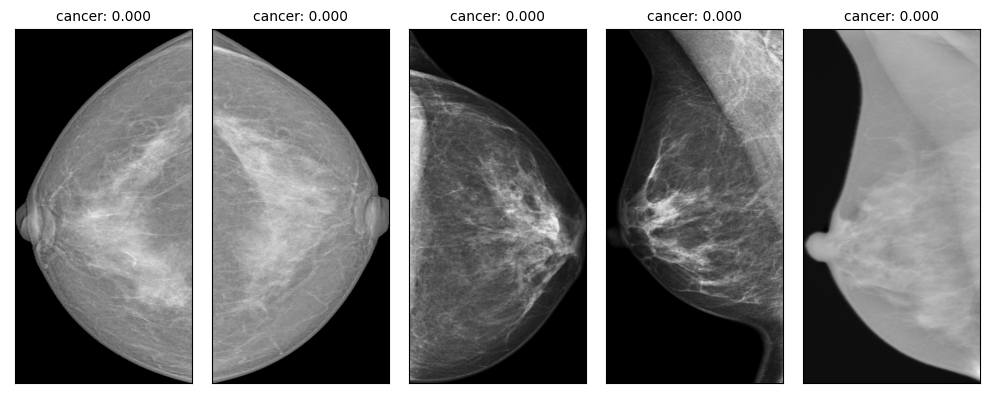

In [19]:
display_batch(batch, 5);

## MixUp

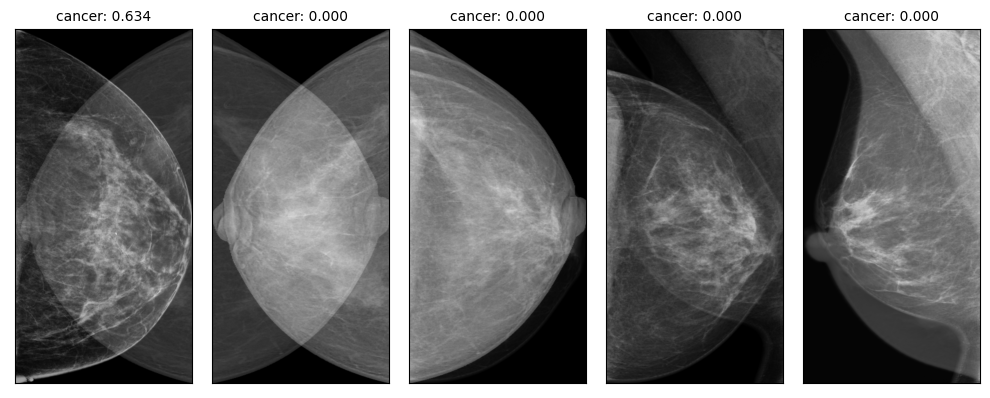

In [20]:
mixup = get_mixup(alpha=2.5, prob=1)
mimgs, mtars = mixup(batch[0], batch[1])
display_batch((mimgs, mtars), 5);

## CutMix

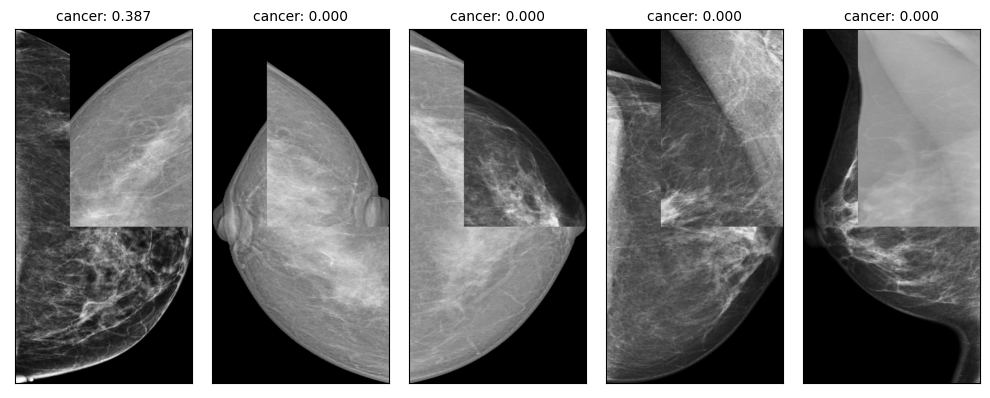

In [21]:
cutmix = get_cutmix(alpha=2.5, prob=1)
cimgs, ctars = cutmix(batch[0], batch[1])
display_batch((cimgs, ctars), 5);

## Dropout

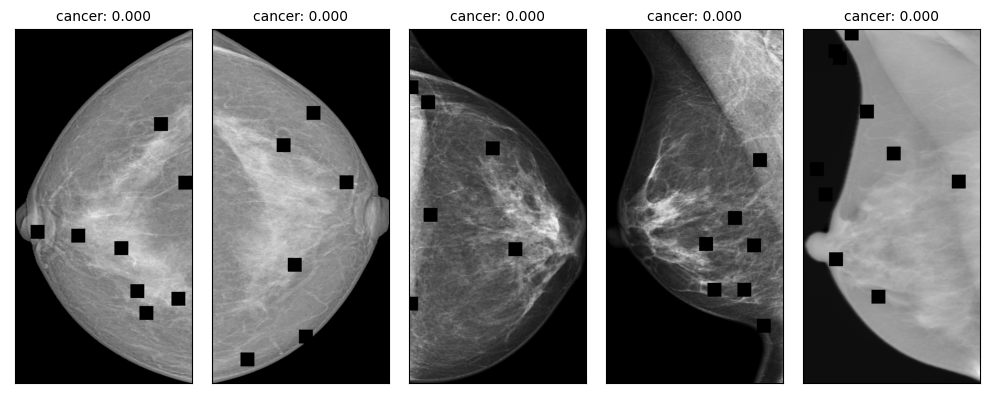

In [22]:
dimgs = tf.map_fn(lambda img: dropout(img,
                DIM=CFG.img_size, 
                PROBABILITY=1.0, 
                CT=10,
                SZ=0.08), batch[0])
dtars = batch[1]
display_batch((dimgs, dtars), 5);

## Affine Transform

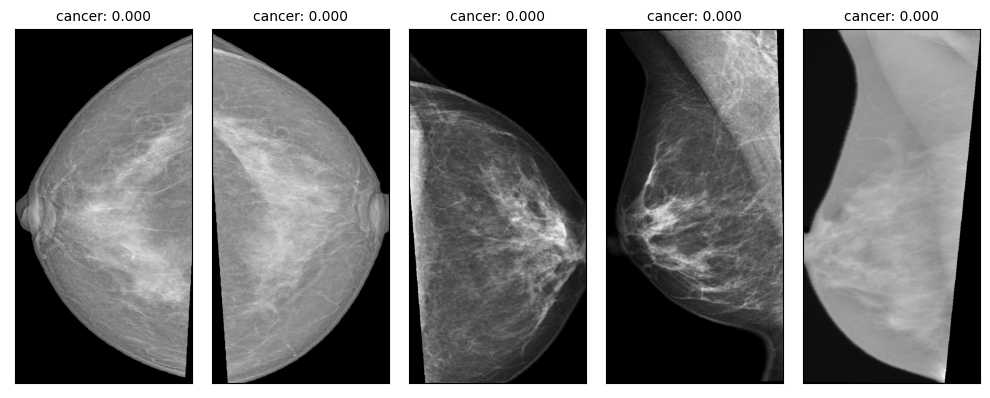

In [23]:
timgs = tf.map_fn(lambda img: transform(img,DIM=CFG.img_size), batch[0])
ttars = batch[1]
display_batch((timgs, ttars), 5);

# Loss Function
## BCE
Loss Function for this notebook is **BCE: Binary Crossentropy** or **Focal** as the task is **binary classification**

$$\textrm{BCE}  = -\frac{1}{N} \sum_{i=1}^{N} y_i \cdot log(\hat{y}_i) + (1 - y_i) \cdot log(1 - \hat{y}_i)$$

where $\hat{y}_i$ is the **predicted** value and $y_i$ is the **original** value for each instance $i$.

## Focal
$$\textrm{FL} = -\alpha_{t}(1 - p_{t})^{\gamma}\log{p_{t}}$$

$\gamma$ controls the shape of the curve. The higher the value of $\gamma$, the lower the loss for well-classified examples, so we could turn the attention of the model more towards ‘hard-to-classify examples. FL gives high weights to the rare class and small weights to the dominating or common class. These weights are referred to as $\alpha$.


## Code
* `tf.keras.losses.BinaryCrossentropy`
* `tfa.losses.SigmoidFocalCrossEntropy`

# Metric
Metric for this competition is **probabilistic F1 score (pF1)**. This extension of the traditional F score accepts probabilities instead of binary classifications,

$$
pF1=2\frac{pPrecision⋅pRecall}{pPrecision+pRecall}
$$

Where,
$$
pPrecision=\frac{pTP}{pTP+pFP}
$$
$$
pRecall=\frac{pTP}{TP+FN}
$$

In [24]:
# tensorflow

class pFBeta(tf.keras.metrics.Metric):
    """Compute overall probabilistic F-beta score."""
    def __init__(self, beta=1, epsilon=1e-5, name='pF1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.beta = beta
        self.epsilon = epsilon
        self.pos = self.add_weight(name='pos', initializer='zeros')
        self.ctp = self.add_weight(name='ctp', initializer='zeros')
        self.cfp = self.add_weight(name='cfp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 0, 1)
        pos = tf.reduce_sum(y_true)
        ctp = tf.reduce_sum(y_pred[y_true==1])
        cfp = tf.reduce_sum(y_pred[y_true==0])
        self.pos.assign_add(pos)
        self.ctp.assign_add(ctp)
        self.cfp.assign_add(cfp)

    def result(self):
        beta_squared = self.beta * self.beta
        c_precision = self.ctp / (self.ctp + self.cfp + self.epsilon)
        c_recall = self.ctp / (self.pos + self.epsilon)
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return tf.cond(c_precision > 0 and c_recall > 0, lambda: result, lambda: 0.0)


# computes batch-wise pfbeta
def pfbeta_tf(labels, preds, beta=1):
    eps = 1e-5
    preds = tf.clip_by_value(preds, 0, 1)
    y_true_count = tf.reduce_sum(labels)
    ctp = tf.reduce_sum(preds[labels==1])
    cfp = tf.reduce_sum(preds[labels==0])
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp + eps)
    c_recall = ctp / (y_true_count + eps)
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + eps)
        return result
    else:
        return tf.constant(0.0, dtype=tf.float32)

# finds best pf1 using thresholds
def pfbeta_thr(labels, preds):
    thrs = tf.range(0, 1, 0.05)
    best_score = tf.constant(0, dtype=tf.float32)
    for thr in thrs:
        score = pfbeta_tf(labels, tf.cast(preds>thr, tf.float32))
        best_score = tf.cond(score > best_score, lambda: score, lambda: best_score)
    return best_score

pfbeta_thr.__name__='pF1_thr'


# numpy
def pfbeta(labels, preds, beta=1):
    eps = 1e-5
    preds = preds.clip(0, 1)
    y_true_count = labels.sum()
    ctp = preds[labels==1].sum()
    cfp = preds[labels==0].sum()
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp + eps)
    c_recall = ctp / (y_true_count + eps)
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + eps)
        return result
    else:
        return 0.0

# Build Model

In [25]:
from keras_cv_attention_models import efficientnet

def build_model(model_name=CFG.model_name,
                loss_name=CFG.loss,
                dim=CFG.img_size,
                compile_model=True,
                include_top=False):         
    base = getattr(efficientnet, model_name)(input_shape=(*dim,3),
                                    pretrained='imagenet',
                                    num_classes=0) # get base model (efficientnet), use imgnet weights
    inp = base.inputs
    x = base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x) # use GAP to get pooling result form conv outputs
    x = tf.keras.layers.Dense(32, activation='silu')(x) # use activation to apply non-linearity
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x) # use sigmoid to convert predictions to [0-1]
    model = tf.keras.Model(inputs=inp,outputs=x)
    if compile_model:
        # optimizer
        opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
        # loss
        if loss_name == 'BCE':
            loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
        elif loss_name == 'Focal':
            loss = tfa.losses.SigmoidFocalCrossEntropy(alpha=0.80, gamma=2.0)
        # metric
        auc = tf.keras.metrics.AUC(name='auc')
        pf1 = pFBeta(name='pF1')
        pf1_thr = pfbeta_thr
        metrics = [pf1, pf1_thr, auc]
        # compile
        model.compile(optimizer=opt,
                      loss=loss,
                      metrics=metrics)
    return model

## Model Check

In [26]:
tmp = build_model(CFG.model_name, dim=CFG.img_size, compile_model=True)
# tmp.summary()  # too long

79202800/79202800 [==============================] - 1s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv1-b4-imagenet.h5


# Learning-Rate Scheduler

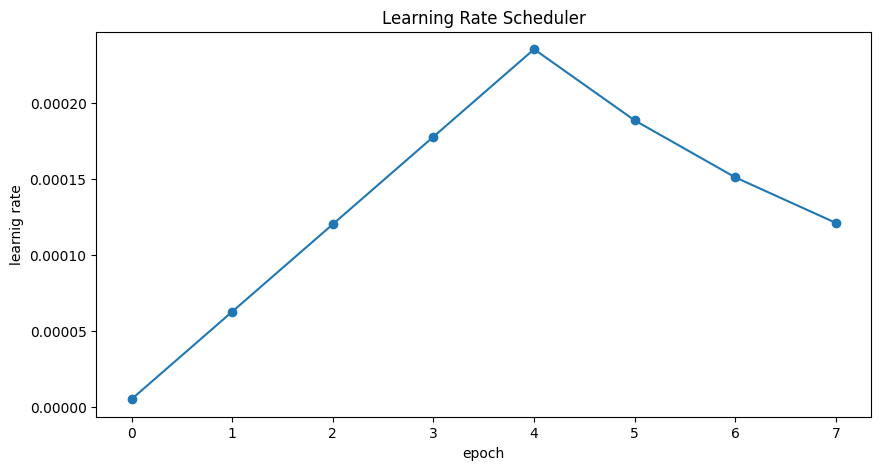

In [27]:
def get_lr_callback(batch_size=8, plot=False):
    lr_start   = 0.000005
    lr_max     = 0.00000105 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        elif CFG.scheduler=='exp':
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        elif CFG.scheduler=='cosine':
            decay_total_epochs = CFG.epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            cosine_decay = 0.4 * (1 + math.cos(phase))
            lr = (lr_max - lr_min) * cosine_decay + lr_min
        return lr
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(CFG.epochs), [lrfn(epoch) for epoch in np.arange(CFG.epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

_=get_lr_callback(CFG.batch_size, plot=True )

# Grad-CAM
Gradient-weighted Class Activation Mapping (Grad-CAM), uses the class-specific gradient information flowing into the final convolutional layer of a CNN to produce a coarse localization map of the important regions in the image. Grad-CAM is a strict generalization of the Class Activation Mapping. Grad-CAM provides visual explanations to better understand image classification problems.

<img src="http://gradcam.cloudcv.org/static/images/network.png" width="800">

In [28]:
import matplotlib.cm as cm, cv2
from tensorflow import keras

def gen_gradcam_heatmap(img, model, last_conv, pred_index=0):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        features, preds = grad_model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, features)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    features = features[0]
    heatmap = features @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def get_gradcam(img, model,  alpha=0.4, show=False):

    heatmap = gen_gradcam_heatmap(img, model, last_conv='stack_6_block1_output', pred_index=0)
    img     = img[0]
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors  = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = cv2.resize(jet_heatmap, dsize=(img.shape[1], img.shape[0]))

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
#     superimposed_img = np.uint8(superimposed_img*255.0)

    # Display Grad CAM
    if show:
        plt.imshow(superimposed_img)
        
    return superimposed_img

# **Wandb** Logger
Log:
* Best Score
* Attention MAP

In [29]:
# create directory to save gradcam imgs
!mkdir -p gradcam

# intialize wandb run
def wandb_init(fold):
    config = {k:v for k,v in dict(vars(CFG)).items() if '__' not in k}
    config.update({"fold":int(fold)})
    yaml.dump(config, open(f'/kaggle/working/config fold-{fold}.yaml', 'w'),)
    config = yaml.load(open(f'/kaggle/working/config fold-{fold}.yaml', 'r'), Loader=yaml.FullLoader)
    run    = wandb.init(project="rsna-bcd-public",
               name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
               config=config,
               anonymous=anonymous,
               group=CFG.exp_name
                    )
    return run

def log_wandb(fold):
    "log best result for error analysis"
    valid_df = df.query("fold==@fold").copy().reset_index(drop=True)
    if CFG.debug:
        valid_df = valid_df[:min_samples]
    valid_df['pred'] = oof_pred[fold].reshape(-1)
    valid_df['diff'] = abs(valid_df.cancer - valid_df.pred)
    valid_df = valid_df.sort_values(by='diff', ascending=False)
    
    noimg_cols  = ['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'age',
                   'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density',
                   'machine_id', 'difficult_negative_case','width','height', 'fold'] + ['pred','diff']
    
    # select top and worst 10 cases for each class
    gradcam_df  = pd.concat((valid_df.groupby('cancer').tail(10), 
                             valid_df.groupby('cancer').head(10)), axis=0, ignore_index=True)
    gradcam_ds  = build_dataset(gradcam_df.image_path, labels=None, cache=False, batch_size=1,
                   repeat=False, shuffle=False, augment=False)
    
    # create wandb table for upload
    data = []
    for idx, img in enumerate(tqdm(gradcam_ds, total=40, desc='gradcam ', position=0, leave=True)):
        gradcam = get_gradcam(img, model)
        row = gradcam_df[noimg_cols].iloc[idx].tolist()
        img = img.numpy()[0]
        img = (img*255.0).astype('uint8')
        data+=[[*row, wandb.Image(img), wandb.Image(gradcam)]]
        if idx<10: # save best ones
            cv2.imwrite(f'gradcam/fold{fold}_{idx:02d}.png', np.concatenate([img, gradcam], axis=1))
    wandb_table = wandb.Table(data=data, columns=[*noimg_cols, 'image', 'gradcam'])
    
    # log values to wandb
    best_epoch = np.argmax(history.history['val_pF1_thr'])
    wandb.log({
               'best_pF1_batch':oof_val[-1], 
               'best_pF1':pF1,
               'best_pF1_thr':pF1_thr,
               'best_auc':auc,
               'best_epoch':best_epoch,
               'viz_table':wandb_table,
              })

## `WandbModelCheckpoint` and `WandbMetricsLogger`
Newly released callbacks offers more flexibility in terms of customization and also they are compact comparing classic `WandbCallback` hence it easier to use. Here's a brief intro about them,

* **WandbModelCheckpoint**: This callback saves model or weights using `tf.keras.callbacks.ModelCheckpoint`, hence we can harness the power of official tf callback to do so much more such log `tf.keras.Model` subclass model in TPU. 

* **WandbMetricsLogger**: This callback simply logs all the metrics and losses.

* **WandbEvalCallback**: This one is even more special, we can use it to log model's prediction after certain epoch/frequency. We can use it to save segmentation mask, bounding boxes and gradcam within epochs to check intermediate result.

For more details, check [here](https://docs.wandb.ai/ref/python/integrations/keras)

In [30]:
# get wandb callbacks
def get_wb_callbacks(fold):
    wb_ckpt = wandb.keras.WandbModelCheckpoint(filepath='fold-%i.h5'%fold, 
                                               monitor='val_pF1_thr',
                                               verbose=CFG.verbose,
                                               save_best_only=True,
                                               save_weights_only=False,
                                               mode='max',)
    wb_metr = wandb.keras.WandbMetricsLogger()
    return [wb_ckpt, wb_metr]

# Train Model
* Cross-Validation: 5 fold
* **WandB** dashboard is shown end of the each fold. So we don't need to plot anything. We can select best model from here.

In [31]:
oof_pred = []; oof_tar = []; oof_val = []; oof_ids = []; oof_folds = []
preds = np.zeros((test_df.shape[0],1))

for fold in np.arange(CFG.folds):
    
    # ignore not selected folds
    if fold not in CFG.selected_folds:
        continue
        
    # init wandb
    if CFG.wandb:
        run = wandb_init(fold)
        wb_callbacks = get_wb_callbacks(fold)
            
    # train and valid dataframe
    train_df = df.query("fold!=@fold")
    valid_df = df.query("fold==@fold")
    
    # upsample cancer data
    pos_df = train_df.query("cancer==1").sample(frac=CFG.upsample, replace=True)
    neg_df = train_df.query("cancer==0")
    train_df = pd.concat([pos_df, neg_df], axis=0, ignore_index=True)
    
    # get image_paths and labels
    train_paths = train_df.image_path.values; train_labels = train_df[CFG.target_col].values.astype(np.float32)
    valid_paths = valid_df.image_path.values; valid_labels = valid_df[CFG.target_col].values.astype(np.float32)
    test_paths  = test_df.image_path.values
    
    # shuffle train data
    index = np.arange(len(train_df))
    np.random.shuffle(index)
    train_paths  = train_paths[index]
    train_labels = train_labels[index]
    
    # min samples in debug mode
    min_samples = CFG.batch_size*REPLICAS*2
    
    # compute class weight (imbalance)
    class_weight = compute_class_weight(class_weight='balanced',
                                        classes=train_df.cancer.unique(),
                                        y=train_df.cancer.values)
    class_weight = dict(zip(df.cancer.unique(), class_weight))
    
    # for debug model run on small portion
    if CFG.debug:
        train_paths = train_paths[:min_samples]; train_labels = train_labels[:min_samples]
        valid_paths = valid_paths[:min_samples]; valid_labels = valid_labels[:min_samples]
    
    # show message
    print('#'*40); print('#### FOLD: ',fold)
    print('#### IMAGE_SIZE: (%i, %i) | MODEL_NAME: %s | BATCH_SIZE: %i'%
          (CFG.img_size[0],CFG.img_size[1],CFG.model_name,CFG.batch_size*REPLICAS))
    
    # data stat
    num_train = len(train_paths)
    num_valid = len(valid_paths)
    if CFG.wandb:
        wandb.log({'num_train':num_train,
                   'num_valid':num_valid})
    print('#### NUM_TRAIN: {:,} | NUM_VALID: {:,}'.format(num_train, num_valid))
    
    # build model
    K.clear_session()
    with strategy.scope():
        model = build_model(CFG.model_name, dim=CFG.img_size, compile_model=True)

    # build dataset
    cache = 0
    train_ds = build_dataset(train_paths, train_labels, cache=cache, batch_size=CFG.batch_size*REPLICAS,
                   repeat=True, shuffle=True, augment=CFG.augment)
    val_ds = build_dataset(valid_paths, valid_labels, cache=cache, batch_size=CFG.batch_size*REPLICAS,
                   repeat=False, shuffle=False, augment=False)
    print('#'*40)   
    
    # callbacks
    callbacks = []
    ## save best model after each fold
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_pF1_thr', verbose=CFG.verbose, save_best_only=True,
        save_weights_only=False, mode='max', save_freq='epoch')
    callbacks +=[sv]
    ## lr-scheduler
    callbacks += [get_lr_callback(CFG.batch_size)]
    ## wandb callbacks
    if CFG.wandb:
        callbacks += wb_callbacks
        
    # train
    print('Training...')
    history = model.fit(
        train_ds, 
        epochs=CFG.epochs if not CFG.debug else 2, 
        callbacks = callbacks, 
        steps_per_epoch=len(train_paths)/CFG.batch_size//REPLICAS,
        validation_data=val_ds, 
        class_weight = class_weight if CFG.use_cw else None,
        verbose=CFG.verbose
    )
    
    # load best model for inference
    print('Loading best model...')
    model.load_weights('fold-%i.h5'%fold)  
    
    # predict on valid data
    print('Predicting OOF with TTA...')
    ds_valid = build_dataset(valid_paths, labels=None, cache=False, batch_size=CFG.batch_size*REPLICAS*2,
                   repeat=True, shuffle=False, augment=CFG.tta>1)
    ct_valid = len(valid_paths); STEPS = CFG.tta * ct_valid/CFG.batch_size/2/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=CFG.verbose)[:CFG.tta*ct_valid,] 
    oof_pred.append(np.mean(pred.reshape((CFG.tta, ct_valid,-1)),axis=0))                 
    
    # get id and target for valid data
    oof_tar.append(valid_df[CFG.target_col].values[:(min_samples if CFG.debug else len(valid_df))])
    oof_folds.append(np.ones_like(oof_tar[-1],dtype='int8')*fold)
    oof_ids.append(valid_df.image_path.tolist()[:(min_samples if CFG.debug else len(valid_df))])
    
#     # predict on test data
#     print('Predicting Test...')
#     ds_test = build_dataset(test_paths, labels=None, cache=False, 
#                     batch_size=(CFG.batch_size*2 if len(test_df)>4 else 1)*REPLICAS,
#                    repeat=True, shuffle=False, augment=CFG.tta>1)
#     ct_test = len(test_paths); STEPS = 1 if len(test_df)<=4 else (CFG.tta * ct_test/CFG.batch_size/2/REPLICAS)
#     pred = model.predict(ds_test,steps=STEPS,verbose=CFG.verbose)[:CFG.tta*ct_test,] 
#     preds[:ct_test, :] += np.mean(pred.reshape((CFG.tta, ct_test,-1)),axis=0) / CFG.folds # not meaningful for DIBUG = True
    
    # store best results
    y_true = oof_tar[-1].astype(np.float32); y_pred = oof_pred[-1]
    pF1 = pfbeta(y_true, y_pred)
    pF1_thr = pfbeta_thr(y_true, y_pred).numpy() # tf metric
    auc = roc_auc_score(y_true, y_pred)
    oof_val.append(np.max(history.history['val_pF1'] ))
    print('>>>> FOLD %i OOF pF1_batch = %.3f, pF1 = %.3f, pF1_thr = %.3f, auc = %.3f\n'%(fold,oof_val[-1], 
                                                                                         pF1, 
                                                                                         pF1_thr,
                                                                                         auc))  # pF1_batch => pF1 batchwise canculated then aggregated
    
    # log best result on wandb & plot
    if CFG.wandb:
        log_wandb(fold) # log
        wandb.run.finish() # finish the run
        display(ipd.IFrame(run.url, width=1080, height=720)) # show wandb dashboard

wandb: Currently logged in as: awsaf49. Use `wandb login --relogin` to force relogin


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


########################################
#### FOLD:  0
#### IMAGE_SIZE: (1024, 512) | MODEL_NAME: EfficientNetV1B4 | BATCH_SIZE: 224
#### NUM_TRAIN: 52,056 | NUM_VALID: 10,840
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv1-b4-imagenet.h5
########################################
Training...
Epoch 1/8
232/232 [==============================] - ETA: 0s - loss: 0.0521 - pF1: 0.2613 - pF1_thr: 0.3595 - auc: 0.5749
Epoch 1: val_pF1_thr improved from -inf to 0.06988, saving model to fold-0.h5

Epoch 1: val_pF1_thr improved from -inf to 0.06988, saving model to fold-0.h5
232/232 [==============================] - 898s 3s/step - loss: 0.0521 - pF1: 0.2613 - pF1_thr: 0.3595 - auc: 0.5749 - val_loss: 0.0330 - val_pF1: 0.0449 - val_pF1_thr: 0.0699 - val_auc: 0.6148 - lr: 5.0000e-06
Epoch 2/8
232/232 [==============================] - ETA: 0s - loss: 0.0434 - pF1: 0.3011 - pF1_thr: 0.5461 - auc: 0.7759
Epoch 2: val_pF1_thr improved from 0.06988 to 0.11550, saving model

gradcam : 100%|██████████| 40/40 [03:37<00:00,  5.43s/it]


best_auc,▁
best_epoch,▁
best_pF1,▁
best_pF1_batch,▁
best_pF1_thr,▁
epoch/auc,▁▄▇█████
epoch/epoch,▁▂▃▄▅▆▇█
epoch/learning_rate,▁▃▄▆█▇▅▅
epoch/loss,█▇▅▃▂▂▁▁
epoch/lr,▁▃▄▆█▇▅▅
epoch/pF1,▁▁▃▄▅▇██


########################################
#### FOLD:  1
#### IMAGE_SIZE: (1024, 512) | MODEL_NAME: EfficientNetV1B4 | BATCH_SIZE: 224
#### NUM_TRAIN: 51,981 | NUM_VALID: 11,005
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv1-b4-imagenet.h5
########################################
Training...
Epoch 1/8
232/232 [==============================] - ETA: 0s - loss: 0.0519 - pF1: 0.2653 - pF1_thr: 0.3714 - auc: 0.5972
Epoch 1: val_pF1_thr improved from -inf to 0.06344, saving model to fold-1.h5

Epoch 1: val_pF1_thr improved from -inf to 0.06344, saving model to fold-1.h5
232/232 [==============================] - 923s 3s/step - loss: 0.0519 - pF1: 0.2653 - pF1_thr: 0.3714 - auc: 0.5972 - val_loss: 0.0340 - val_pF1: 0.0421 - val_pF1_thr: 0.0634 - val_auc: 0.5722 - lr: 5.0000e-06
Epoch 2/8
232/232 [==============================] - ETA: 0s - loss: 0.0424 - pF1: 0.3096 - pF1_thr: 0.5715 - auc: 0.7931
Epoch 2: val_pF1_thr improved from 0.06344 to 0.12190, saving model

gradcam : 100%|██████████| 40/40 [03:35<00:00,  5.38s/it]


best_auc,▁
best_epoch,▁
best_pF1,▁
best_pF1_batch,▁
best_pF1_thr,▁
epoch/auc,▁▄▇█████
epoch/epoch,▁▂▃▄▅▆▇█
epoch/learning_rate,▁▃▄▆█▇▅▅
epoch/loss,█▇▄▃▂▁▁▁
epoch/lr,▁▃▄▆█▇▅▅
epoch/pF1,▁▂▃▄▆▇██


########################################
#### FOLD:  2
#### IMAGE_SIZE: (1024, 512) | MODEL_NAME: EfficientNetV1B4 | BATCH_SIZE: 224
#### NUM_TRAIN: 52,331 | NUM_VALID: 10,952
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv1-b4-imagenet.h5
########################################
Training...
Epoch 1/8
233/233 [==============================] - ETA: 0s - loss: 0.0531 - pF1: 0.2704 - pF1_thr: 0.3722 - auc: 0.5724
Epoch 1: val_pF1_thr improved from -inf to 0.05543, saving model to fold-2.h5

Epoch 1: val_pF1_thr improved from -inf to 0.05543, saving model to fold-2.h5
233/233 [==============================] - 899s 3s/step - loss: 0.0531 - pF1: 0.2704 - pF1_thr: 0.3722 - auc: 0.5724 - val_loss: 0.0344 - val_pF1: 0.0371 - val_pF1_thr: 0.0554 - val_auc: 0.6071 - lr: 5.0000e-06
Epoch 2/8
233/233 [==============================] - ETA: 0s - loss: 0.0437 - pF1: 0.3130 - pF1_thr: 0.5646 - auc: 0.7821
Epoch 2: val_pF1_thr improved from 0.05543 to 0.10480, saving model

gradcam : 100%|██████████| 40/40 [03:39<00:00,  5.49s/it]


best_auc,▁
best_epoch,▁
best_pF1,▁
best_pF1_batch,▁
best_pF1_thr,▁
epoch/auc,▁▄▇█████
epoch/epoch,▁▂▃▄▅▆▇█
epoch/learning_rate,▁▃▄▆█▇▅▅
epoch/loss,█▇▅▃▂▁▁▁
epoch/lr,▁▃▄▆█▇▅▅
epoch/pF1,▁▂▃▄▅▇██


# Visualize Grad-CAM

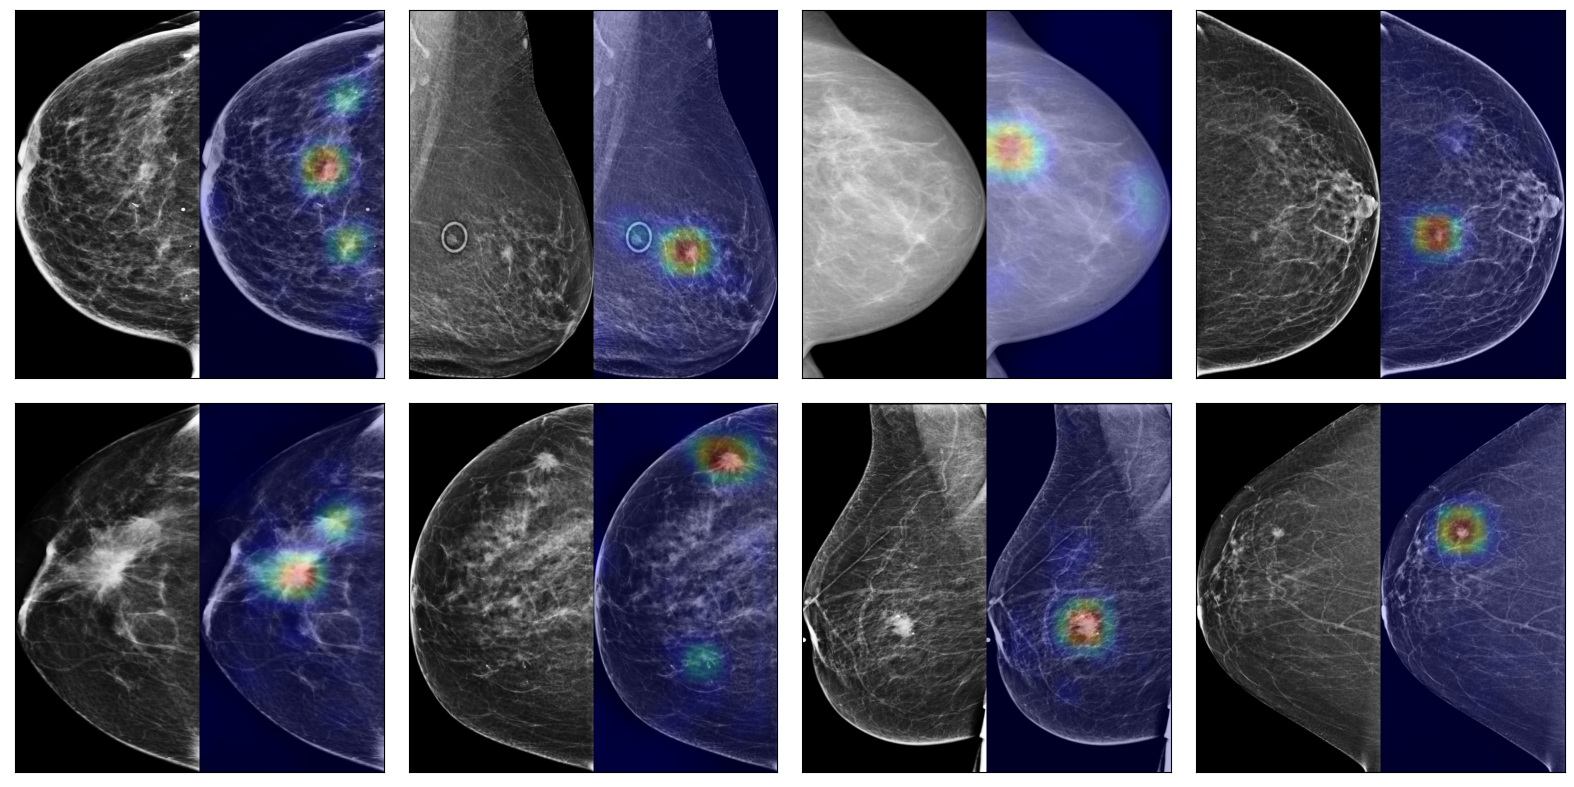

In [32]:
from mpl_toolkits.axes_grid1 import ImageGrid

imgs = [cv2.imread(path) for path in glob('/kaggle/working/gradcam/*')[:8]]
fig = plt.figure(figsize=(20., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 4),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, imgs):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Calculate OOF Score

In [33]:
# overall oof pF1
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
ids = np.concatenate(oof_ids); folds = np.concatenate(oof_folds)
pF1 = pfbeta(true.astype(np.float32),oof)
print('Overall OOF pF1 = %.3f'%pF1)

Overall OOF pF1 = 0.084


In [34]:
# save oof
columns = ['image_path', 'true', 'pred']
df_oof = pd.DataFrame(np.concatenate([ids[:,None], true, oof], axis=1), columns=columns)
df_oof = df_oof.merge(df, on=['image_path'], how='left') # merge with train data
df_oof.to_csv('oof.csv',index=False)
df_oof.head(2)

,image_path,true,pred,site_id,patient_id,image_id,laterality,view,age,cancer,...,BIRADS,implant,density,machine_id,difficult_negative_case,width,height,age_bin,stratify,fold
0,/kaggle/input/rsna-bcd-roi-1024x512-png-v2-dat...,0,0.30886984,1,10038,1967300488,L,MLO,60.0,0,...,1.0,0,C,216,False,294,888,2.0,LMLO001.02.00C216False0,0.0
1,/kaggle/input/rsna-bcd-roi-1024x512-png-v2-dat...,0,0.20724404,1,10038,2142944869,L,CC,60.0,0,...,1.0,0,C,216,False,295,718,2.0,LCC001.02.00C216False0,0.0


# `pF1` Maximize

100%|██████████| 20/20 [00:00<00:00, 100.55it/s]



## MAX pF1 =  0.184 @ 0.650



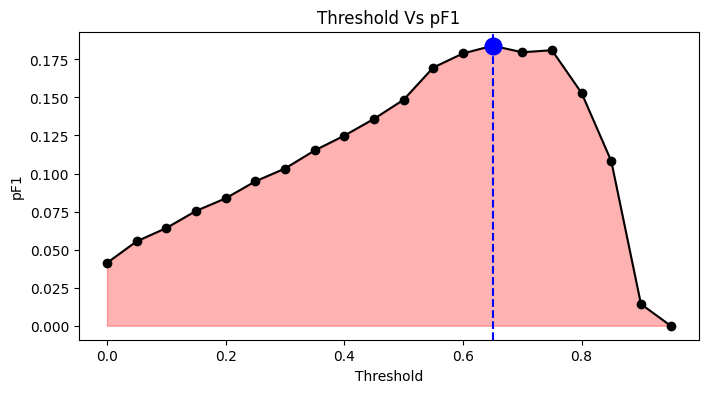

In [35]:
# calculate pf1 for multiple thresholds
thrs = np.arange(0,1,0.05)
scores = []
for thr in tqdm(thrs):
    scores+=[pfbeta(df_oof.true.astype('float32'), df_oof.pred.astype('float32')>thr)]
    
# get best thr for max pF1
best_score_idx = np.argmax(scores)
best_score = np.max(scores)
best_thr = thrs[best_score_idx]
print(f'\n## MAX pF1 = {best_score: 0.3f} @ {best_thr:0.3f}\n')

# plot thr vs pF1 graph
fig, ax = plt.subplots(figsize=(8,4))
ax.fill_between(thrs, scores,
                color='red', alpha=0.3, )
ax.plot(thrs, scores, '-ok');
ax.axvline(x=best_thr, color='blue', ls='--')
ax.plot(best_thr, best_score, color='blue', marker='o', markersize=12)
ax.set_xlabel('Threshold');
ax.set_ylabel('pF1');
ax.set_title('Threshold Vs pF1');

# Prediction Distribution of OOF & Train 
Check **Cancer** distribution of `train` and `oof`. 

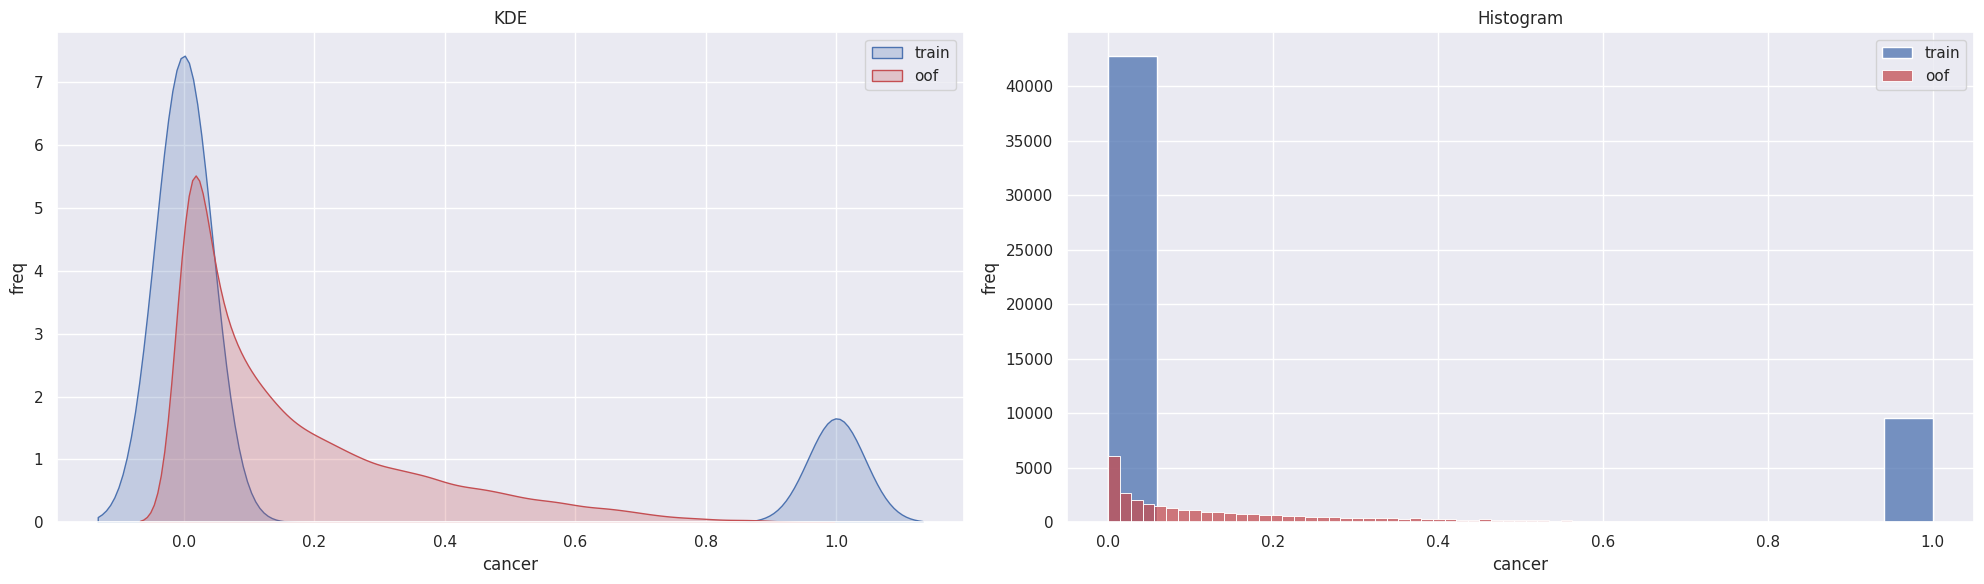

In [36]:
import seaborn as sns
sns.set(style='dark')

plt.figure(figsize=(10*2,6))

plt.subplot(1, 2, 1)
sns.kdeplot(x=train_df[CFG.target_col[0]], color='b',fill=True);
sns.kdeplot(x=df_oof.pred.values.astype('float32'), color='r',fill=True);
plt.grid('ON')
plt.xlabel(CFG.target_col[0]);plt.ylabel('freq');plt.title('KDE')
plt.legend(['train', 'oof'])

plt.subplot(1, 2, 2)
sns.histplot(x=train_df[CFG.target_col[0]], color='b');
sns.histplot(x=df_oof.pred.values.astype('float32'), color='r');
plt.grid('ON')
plt.xlabel(CFG.target_col[0]);plt.ylabel('freq');plt.title('Histogram')
plt.legend(['train', 'oof'])

plt.tight_layout()
plt.show()

# Remove Files

In [37]:
!rm -r /kaggle/working/wandb

# Reference:
1. [RANZCR: EfficientNet TPU Training](https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training)
1. [Triple Stratified KFold with TFRecords](https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords)